In [2]:
import Pkg; 

if split(pwd(),"/")[end] == "_paper_1"
    cd(joinpath(@__DIR__, "../../"))
    Pkg.activate("Project.toml")
end

using MorphoMol
using MorphoMol.Algorithms: SimulatedAnnealing, simulate!
using MorphoMolNotebooks: has_hard_sphere_overlap, is_dispersed, configuration_to_poly, calculate_initial_temperature, add_to_simulation_minima!, construct_graph_from_configuration, has_hard_sphere_overlap, is_dispersed, get_random_configuration_without_overlap_in_bounds, is_configuration_equivalent_to_mcc, is_equivalent_configuration, get_mccs, minimal_mcc, get_energies_of_mccs
using GLMakie
using Random
using Distances
using JLD2

  Activating project at `~/Doktor/Code/MorphoMol/MorphoMolNotebooks`


In [15]:
n = 5
pf_id = "virial"
@load "src/assets/$(pf_id)_known_minimal_configurations.jld2" known_minimal_configurations
sim_configurations = []
for key in filter(x -> x.n == n, keys(known_minimal_configurations))
    conf = known_minimal_configurations[key].centers
    mcc = known_minimal_configurations[key].mcc
    dispersed = known_minimal_configurations[key].dispersed
    if !mcc && !dispersed
        push!(sim_configurations, conf)
    end
end

In [16]:
r = 1.0

rss = 0.025:0.025:1.2
etas = 0.34:0.025:0.5
if pf_id == "virial"
    etas = 0.44:0.02:0.644
end

min_energies = [Inf for rs in rss, eta in etas]   
types = [-1 for rs in rss, eta in etas]
minimizing_configurations = Dict{Tuple{Int, Int}, Vector{Float64}}()
exotic_clusters = Dict{Tuple{Int, Int}, Vector{Float64}}()
radii = fill(r, n)
for (i, rs) in enumerate(rss)
    for (j, eta) in enumerate(etas)
        prefactors = MorphoMol.Energies.get_prefactors(rs, eta, pf_id)
        E_disp = n * MorphoMol.Energies.solvation_free_energy([0.0, 0.0, 0.0], [r], rs, prefactors)
        min_mcc = minimal_mcc(n, rs, prefactors)
        
        if min_mcc.E < min_energies[i,j]
            min_energies[i,j], types[i,j] = min_mcc.E, 1
            minimizing_configurations[(i,j)] = min_mcc.centers
        end

        for conf in sim_configurations
            E = MorphoMol.Energies.solvation_free_energy(conf, radii, rs, prefactors)
            if E < min_energies[i,j] && !has_hard_sphere_overlap(conf) && !is_dispersed(conf, rs)
                min_energies[i,j], types[i,j] = E, 2
                minimizing_configurations[(i,j)] = conf
                exotic_clusters[(i,j)] = conf
            end
        end

        if isapprox(min_energies[i,j], E_disp)
            minimizing_configurations[(i,j)] = vcat([[10.0 * i, 0.0, 0.0] for i in 1:n]...)
            types[i,j] = 0
        end
    end
end

types

48×11 Matrix{Int64}:
 2  2  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0
 1  1  0  0  0  0  0  0  0  0  0
 1  1  0  0  0  0  0  0  0  0  0
 1  1  1  0  0  0  0  0  0  0  0
 1  1  2  0  0  0  0  0  0  0  0
 1  1  2  2  0  0  0  0  0  0  0
 1  1  1  2  0  0  0  0  0  0  0
 1  1  1  1  2  0  0  0  0  0  0
 1  1  1  1  1  0  0  0  0  0  0
 1  1  1  1  1  1  0  0  0  0  0
 1  1  1  1  1  1  1  0  0  0  0
 ⋮              ⋮              ⋮
 1  1  1  2  2  2  2  2  2  2  2
 1  1  1  1  2  2  2  2  2  2  2
 1  1  1  2  2  2  2  2  2  2  2
 1  1  1  2  2  2  2  2  2  2  2
 1  1  1  2  2  2  2  2  2  2  2
 1  1  1  2  2  2  2  2  2  2  2
 1  1  1  2  2  2  2  2  2  2  2
 1  1  1  2  2  2  2  2  2  2  2
 1  1  2  2  2  2  2  2  2  2  2
 1  1  1  2  2  2  2  2  2  2  2
 1  1  2  2  2  2  2  2  2  2  2
 1  1  2  2  2  2  2  2  2  2  2

In [17]:
using Graphs
using Graphs.Experimental

In [18]:
isomorphic_minimizers = Dict{Graph, Vector{Tuple{Int, Int}}}()
for (k,v) in exotic_clusters
    rs = rss[k[1]]
    gv = construct_graph_from_configuration(v; threshold= 1.0 + rs)
    already_found = false
    for gu in keys(isomorphic_minimizers)
        if has_isomorph(gv, gu)
            push!(isomorphic_minimizers[gu], k)
            already_found = true
        end
    end
    if !already_found
        isomorphic_minimizers[gv] = [k]
    end
end

In [19]:
try
    rm("assets/output", recursive = true)
catch 
end
mkpath("assets/output")
for (i, all_coords) in enumerate(values(isomorphic_minimizers))
    configuration_to_poly(minimizing_configurations[all_coords[1]], fill(1.0, n), "assets/output/$(i)", n, 1)
end

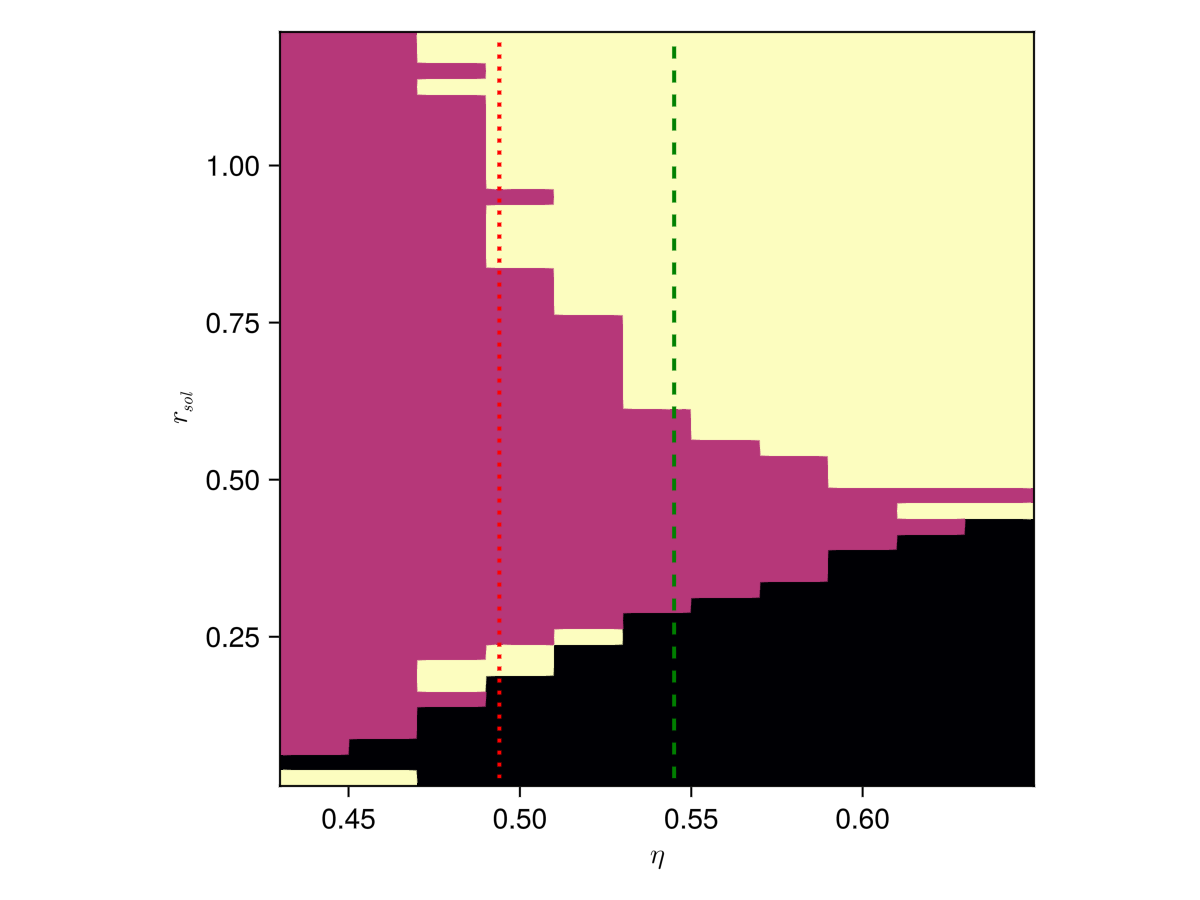

In [20]:
fig = Figure()
cmap = cgrad(:magma, 3, categorical = true)

ax = Axis(fig[1,1], aspect = 1, xlabel = L"\eta", ylabel = L"r_{sol}")

heatmap!(ax, etas, rss, types', colormap = cmap)
lines!(ax, [0.494, 0.494], [rss[1], rss[end]], color = :red, linestyle = :dot, linewidth = 2)
if pf_id == "virial"
    lines!(ax, [0.545, 0.545], [rss[1], rss[end]], color = :green, linestyle = :dash, linewidth = 2)
end
resize_to_layout!(fig)
fig